<a href="https://colab.research.google.com/github/Cheesykung/Sugar-cane-leaves-Recognition/blob/master/learning_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **โปรเจค 3 การทำ Image Recognition แบบ Learning-Based Approach**

### **`กลุ่ม หม่าล่าอ่ะเผ็ดแต่ไม่เด็ดเท่าเรา`**

>  # ***การรู้จำภาพใบอ้อย***

เพื่อจำแนกโรคใบอ้อย ได้แก่
*   ใบอ้อยที่ไม่เป็นโรค (green)
*   ใบอ้อยที่เป็นโรคใบขีดแดง (red)
*   ใบอ้อยที่เป็นโรคใบจุดวงแหวน (ring)
*   ใบอ้อยที่เป็นโรคใบจุดตาล (spot)
*   ใบอ้อยที่เป็นโรคใบด่าง (white)
*   ใบอ้อยที่เป็นโรคใบเหลือง (yellow)







In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Mount Drive เพื่อเชื่อมต่อกับข้อมูลใน Google Drive
import pathlib
data_dir = '/content/drive/MyDrive/Project-sugarcane'
data_dir = pathlib.Path(data_dir) # รับ path มาแปลงเป็น path class

In [ ]:
# เช็คจำนวนภาพทั้งหมด
image_count = len(list(data_dir.glob('*/*.JPG')))
print("จำนวนรูปภาพใน Directory มี", image_count , "ภาพ") 

จำนวนรูปภาพใน Directory มี 60 ภาพ


# **SETTING DATASET**

In [ ]:
# fixed size training resources and label
# กำหนดขนาดภาพที่จะเข้ามา train
batch_size = 1 # จำนวนภาพที่นำมาเข้าชุด ในการ train และ test แต่ละรอบ เช่น ภาพ  
img_height = 180 # ความสูงภาพ
img_width = 180 # ความกว้างภาพ
img_size = (img_height,img_width)

In [ ]:
# training data selection
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, # กำหนด path ที่อยู่ของข้อมูล โดยพารามิเตอร์นี้จะกำหนด Sub-directory เป็น Label และมองไฟล์ภาพ เป็นภาพของ Class นั้น ๆ 
  validation_split= 0.3, # กำหนด % ของจำนวนภาพที่จะเอาไป Test
  subset = "training", #กำหนดว่าเป็นชุด Train 
  seed = 123, # Optional random seed for shuffling and transformations. กำหนดให้มีการสุ่มลำดับในการสลับหรือการแปลงภาพ
  image_size = (img_height, img_width), # กำหนดขนาด 256*256
  batch_size = batch_size) 

Found 60 files belonging to 6 classes.
Using 42 files for training.


In [ ]:
# testing data selection
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset = "validation", #กำหนดว่าเป็นชุด Test
  seed= 123, 
  image_size=(img_height, img_width),
  batch_size = batch_size)
class_names = train_dataset.class_names

Found 60 files belonging to 6 classes.
Using 18 files for validation.


In [ ]:
# เช็คจำนวนและชื่อ class lebel
num_classes = len(train_dataset.class_names)
print("มีคลาสทั้งหมด ", num_classes, "คลาส")
class_names = train_dataset.class_names
print("ได้แก่ ", class_names)


มีคลาสทั้งหมด  6 คลาส
ได้แก่  ['green', 'red', 'ring', 'spot', 'white', 'yellow']


In [ ]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(2, 227, 227, 3)
(2,)


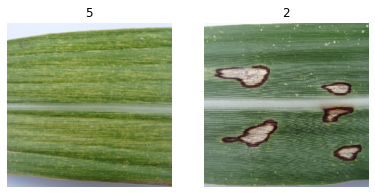

In [ ]:
# พล็อตภาพ
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(batch_size): # กำหนดขนาดแสดงภาพได้ไม่เกิน batch_size
        ax = plt.subplot(2, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# **CREATE Model CONSTRUCTER**

In [ ]:
# กำหนดจำนวนคลาส
num_classes = 6

# กำหนด
model = Sequential([
  # แปลงขนาดให้ภาพ input ให้เป็น [0,1]    
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),                 
  # กำหนดส่วนที่ทำให้ model Robustness
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),

  #Feature extraction
  # สร้าง 1st Convolutions ที่มี output dimension 9*9, filter 3*3
  layers.Conv2D(9, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(18, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(27, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(36, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(45, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.5),

  # Classify - Fully connected
  # รวม Feature Extraction เป็น vector เดียว --> input ของ fullu connected
  layers.Flatten(),
  # 1st Hidden 
  layers.Dense(124, activation='relu'),
  # 2nd Hidden 
  layers.Dense(42, activation='relu'),
  layers.Dropout(0.5),
  # output layer
  layers.Dense(num_classes)
])


In [ ]:
# ดู Diagram ของ Model
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Print network layer of Model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_3 (RandomFlip)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 90, 90, 16)        64        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)       

# **Training dataset**

In [ ]:
#กำหนดครั้ง ที่นำทุกภาพใน batch_size เข้าไป Train 
epochs = 100 #จำนวนรอบที่ trend 

# สอน Model ปรับปรุงแบบจำลอง --> Backward
# ทำการ optimizer ด้วย Adam Algorithms
# ทำการ Crossentropy loss function เพราะมีมากกว่า 2 class label มาช่วยปรับค่า 
# > classes floating point values per feature for y_pred and a single floating point value per feature for y_true
# > The shape of y_true is [batch_size] and the shape of y_pred is [batch_size, num_classes]
# เก็บค่า Metrics เพื่อคำนวณหาความถี่ที่ค่า predict = labels
model.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# fit model สั่งให้โยนภาพ ไปให้โมเดลเรียนรู้
history = model.fit(
  train_dataset,
  validation_data = test_dataset,
  epochs = epochs
)

Epoch 1/100
11/11 [==============================] - 4s 196ms/step - loss: 0.0932 - accuracy: 1.0000 - val_loss: 2.8005 - val_accuracy: 0.5556
Epoch 2/100
11/11 [==============================] - 3s 176ms/step - loss: 0.3200 - accuracy: 0.8960 - val_loss: 3.4465 - val_accuracy: 0.5000
Epoch 3/100
11/11 [==============================] - 2s 172ms/step - loss: 0.1557 - accuracy: 0.9641 - val_loss: 4.2698 - val_accuracy: 0.4444
Epoch 4/100
11/11 [==============================] - 2s 173ms/step - loss: 0.3179 - accuracy: 0.8070 - val_loss: 3.6414 - val_accuracy: 0.4444
Epoch 5/100
11/11 [==============================] - 3s 175ms/step - loss: 0.2265 - accuracy: 0.9449 - val_loss: 3.7051 - val_accuracy: 0.4444
Epoch 6/100
11/11 [==============================] - 3s 173ms/step - loss: 0.0508 - accuracy: 0.9890 - val_loss: 5.7125 - val_accuracy: 0.3333
Epoch 7/100
11/11 [==============================] - 2s 171ms/step - loss: 0.4612 - accuracy: 0.9017 - val_loss: 2.7434 - val_accuracy: 0.4444

# **Visualize training results**

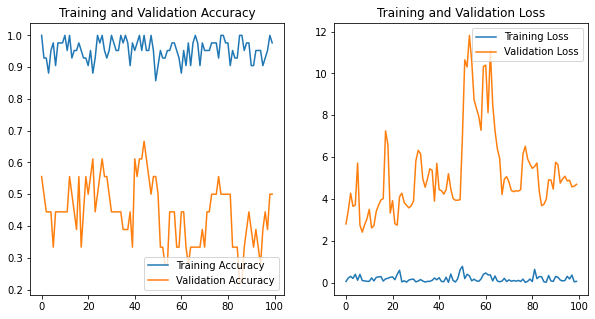

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1) # plot กราฟ 1 แถว 2 หลัก index ที่ 1
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2) # plot กราฟ 1 แถว 2 หลัก index ที่ 2
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Evaluate Model**

In [ ]:
# Evaluate model by using test_dataset
model.evaluate(test_dataset)
# --->> Returns the loss value & metrics values for the model in test mode. Computation is done in batches

5/5 [==============================] - 1s 32ms/step - loss: 5.0114 - accuracy: 0.1111


[5.0114030838012695, 0.1111111119389534]

# **PREDICT CLASS OF IMAGE** 

  - `Import file จาก local storage`
  - `Input path from google drive`

---








  



# `> แบบ Import file จาก local storage`

  

> *หมายเหตุ : การอัปโหลดช้ากว่าการใส่ directory path *italicized text*

In [ ]:
# input ภาพที่ต้องการ predict class
from google.colab import files
predict_files = files.upload()

KeyboardInterrupt: ignored

In [ ]:
print(type(predict_files))
key = predict_files.keys()
key_list = list(predict_files.keys())
print(key_list)

In [ ]:
from skimage.transform import resize
predict_file = plt.imread(key_list[0])
show_predict_file = plt.imshow(predict_file)

In [ ]:
predict_file = resize(predict_file, (img_height,img_width))
show_predict_file_resize = plt.imshow(predict_file)

In [ ]:
file_predictions = model.predict(np.array([predict_file]))
print(file_predictions)
file_score = tf.nn.softmax(file_predictions[0])
print(file_score)

print(
    "This image most likely belongs to {} class with a {:.2f} percent confidence.".format(class_names[np.argmax(file_score)], 100 * np.max(file_score))
)



# `> แบบ input path from google drive`



> *หมายเหตุ : ต้อง Mount Drive กับ Google colab ก่อน หรือ ใส่ path ของภาพจาก local storage







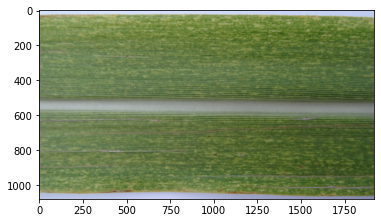

In [ ]:
predict_path = '/content/drive/MyDrive/Project-sugarcane/yellow/DSC00099.JPG'

# นำเข้าภาพ และปรับขนาดให้เท่ากับขนาดภาพ test ให้เท่ากับ ภาพที่ train ใน model
img = keras.preprocessing.image.load_img(
    predict_path, target_size=(img_height, img_width)
)
predict_file = plt.imread(predict_path)
show_predict_file = plt.imshow(predict_file)
# แปลง ภาพ เป็น array
img_array = keras.preprocessing.image.img_to_array(img)
# img_array.shape
# >> output (256, 256, 3)

# ปรับมิติของ array ให้เข้ากับ input ที่จะเข้าไป trend
img_array = tf.expand_dims(img_array, 0) # Create a batch
# img_array.shape
# >> output (1, 256, 256, 3)

In [ ]:
# input ภาพที่ต้องการ predict class
predictions = model.predict(img_array)
print(
    "This image most likely belongs to {} class with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
)

[[-13.06097    -5.794834   -9.457775   -1.2705425  -6.199828   14.563186 ]]
This image most likely belongs to yellow class with a 100.00 percent confidence.
